# Forecasting the Electric Power Consumption of a Household

#### Loading Libraries

In [1]:
# Numerical Computing
import numpy as np
# Data Manipulation
import pandas as pd
# Data manipulation
import datetime
# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data Scalation
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

# Warnings
import warnings

In [2]:
from tensorflow.keras.optimizers.legacy import Adam

In [3]:
warnings.filterwarnings('ignore')

##### Visualization Set Up

In [4]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = True

In [5]:
print(tf.__version__)

2.15.0


In [6]:
# Numerical & Tensorflow Setting Seeds
tf.random.set_seed(42)
np.random.seed(42)

### Loading Data

In [7]:
train_df = pd.read_csv('/Users/isisromero/desktop/time_series/preprocessed/ch18_train.csv')
val_df = pd.read_csv('/Users/isisromero/desktop/time_series/preprocessed/ch18_val.csv')
test_df = pd.read_csv('/Users/isisromero/desktop/time_series/preprocessed/ch18_test.csv')

print(train_df.shape, val_df.shape, test_df.shape)

(24210, 7) (6918, 7) (3459, 7)


##### Data Window Class

In [8]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Global_active_power', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='forestgreen', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

##### Compile & Fit Function

In [9]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [10]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

### Baseline Models

In [11]:
# Baseline Window
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['Global_active_power'])

##### Repeat Last Known Value: Multi-Step Class

In [12]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

##### Performing Baseline Model

In [13]:
# Model Set-Up
baseline_last = MultiStepLastBaseline(label_index=column_indices['Global_active_power'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

215/215 [==============================] - 0s 310us/step - loss: 0.1771 - mean_absolute_error: 0.3039


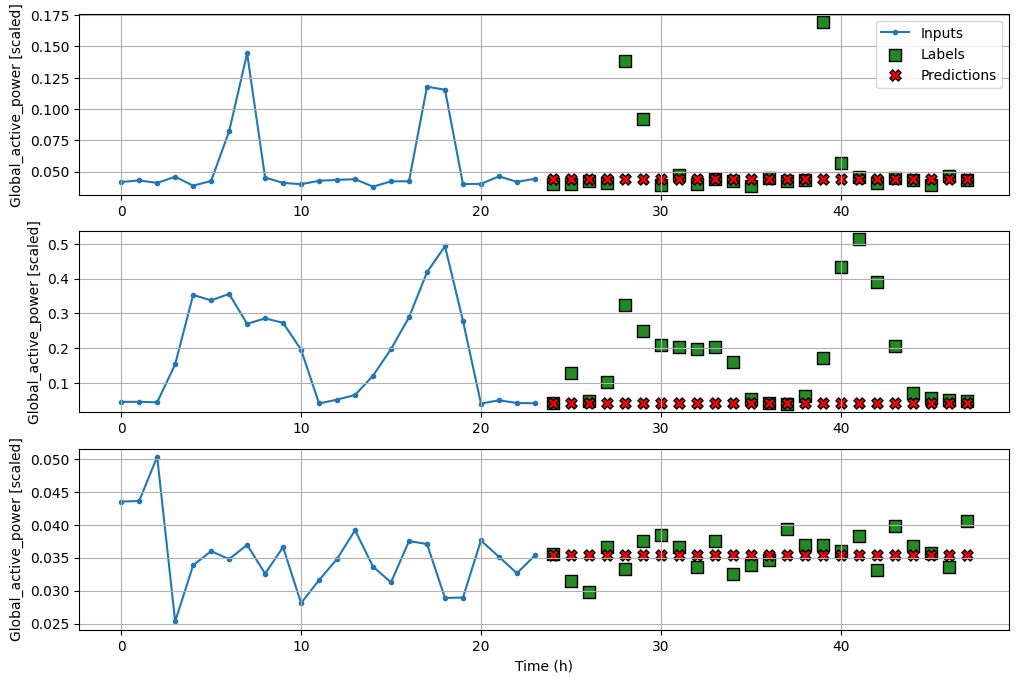

In [14]:
multi_window.plot(baseline_last)

##### Repeated Last Day

In [15]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [16]:
# Repeated Last Day Model Set-Up
baseline_repeat = RepeatBaseline(label_index=column_indices['Global_active_power'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

215/215 [==============================] - 0s 312us/step - loss: 0.1725 - mean_absolute_error: 0.2918


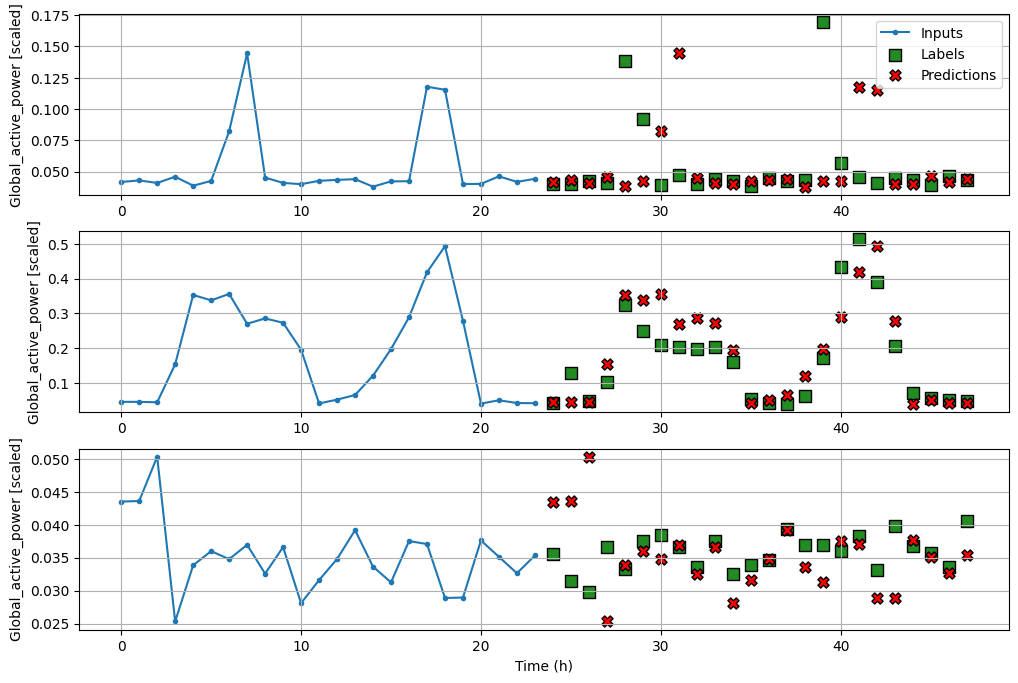

In [17]:
multi_window.plot(baseline_repeat)

#### Performing Linear Model

In [18]:
label_index = column_indices['Global_active_power']
num_features = train_df.shape[1]

# Linear Model Set-Up
linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

# Model Training
history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
756/756 [==============================] - 0s 470us/step - loss: 0.0171 - mean_absolute_error: 0.1009 - val_loss: 0.0131 - val_mean_absolute_error: 0.0870
Epoch 2/50
756/756 [==============================] - 0s 463us/step - loss: 0.0153 - mean_absolute_error: 0.0939 - val_loss: 0.0131 - val_mean_absolute_error: 0.0863
Epoch 3/50
756/756 [==============================] - 0s 454us/step - loss: 0.0153 - mean_absolute_error: 0.0935 - val_loss: 0.0131 - val_mean_absolute_error: 0.0862
Epoch 4/50
756/756 [==============================] - 0s 467us/step - loss: 0.0153 - mean_absolute_error: 0.0935 - val_loss: 0.0131 - val_mean_absolute_error: 0.0865
Epoch 5/50
756/756 [==============================] - 0s 496us/step - loss: 0.0153 - mean_absolute_error: 0.0935 - val_loss: 0.0131 - val_mean_absolute_error: 0.0862
Epoch 6/50
756/756 [==============================] - 0s 450us/step - loss: 0.0153 - mean_absolute_error: 0.0935 - val_loss: 0.0131 - val_mean_absolute_error: 0.0866
Epoc

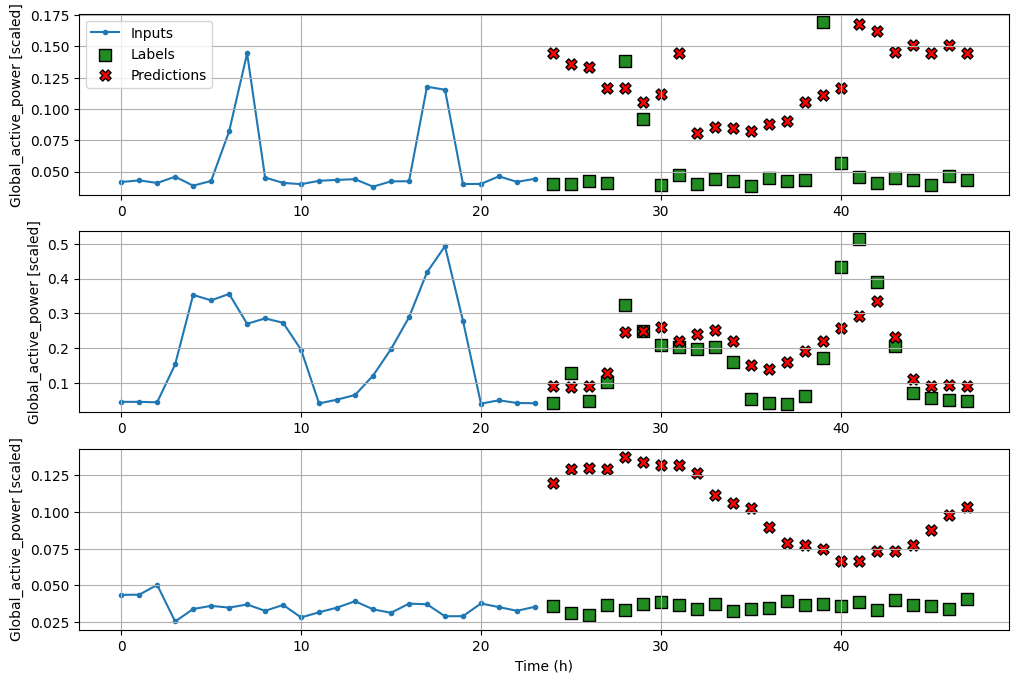

In [19]:
multi_window.plot(linear)

#### Deep Neural Network (DNN)

In [20]:
# DNN Model Set-Up
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

# Model Training
history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
756/756 [==============================] - 1s 903us/step - loss: 0.0147 - mean_absolute_error: 0.0896 - val_loss: 0.0119 - val_mean_absolute_error: 0.0775
Epoch 2/50
756/756 [==============================] - 1s 862us/step - loss: 0.0139 - mean_absolute_error: 0.0863 - val_loss: 0.0120 - val_mean_absolute_error: 0.0817
Epoch 3/50
756/756 [==============================] - 1s 862us/step - loss: 0.0138 - mean_absolute_error: 0.0860 - val_loss: 0.0116 - val_mean_absolute_error: 0.0791
Epoch 4/50
756/756 [==============================] - 1s 864us/step - loss: 0.0137 - mean_absolute_error: 0.0855 - val_loss: 0.0115 - val_mean_absolute_error: 0.0778
Epoch 5/50
756/756 [==============================] - 1s 886us/step - loss: 0.0136 - mean_absolute_error: 0.0851 - val_loss: 0.0114 - val_mean_absolute_error: 0.0777
Epoch 6/50
756/756 [==============================] - 1s 901us/step - loss: 0.0136 - mean_absolute_error: 0.0848 - val_loss: 0.0114 - val_mean_absolute_error: 0.0786
Epoc

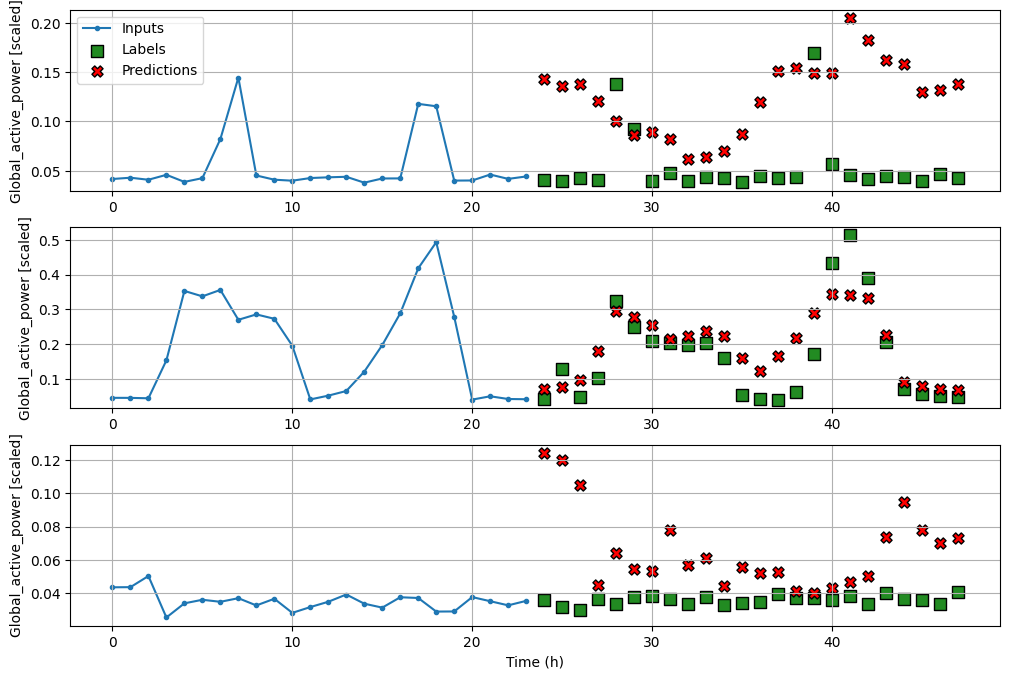

In [21]:
multi_window.plot(dense)

#### Long Short-Term Memory Model (LSTM)

In [22]:
# LSTM Model Set-Up
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

# Model Training
history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
756/756 [==============================] - 2s 2ms/step - loss: 0.0160 - mean_absolute_error: 0.0949 - val_loss: 0.0118 - val_mean_absolute_error: 0.0815
Epoch 2/50
756/756 [==============================] - 2s 2ms/step - loss: 0.0137 - mean_absolute_error: 0.0858 - val_loss: 0.0119 - val_mean_absolute_error: 0.0824
Epoch 3/50
756/756 [==============================] - 2s 2ms/step - loss: 0.0135 - mean_absolute_error: 0.0850 - val_loss: 0.0117 - val_mean_absolute_error: 0.0817
Epoch 4/50
756/756 [==============================] - 2s 2ms/step - loss: 0.0135 - mean_absolute_error: 0.0846 - val_loss: 0.0115 - val_mean_absolute_error: 0.0791
Epoch 5/50
756/756 [==============================] - 2s 2ms/step - loss: 0.0134 - mean_absolute_error: 0.0842 - val_loss: 0.0115 - val_mean_absolute_error: 0.0803
Epoch 6/50
756/756 [==============================] - 2s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0840 - val_loss: 0.0116 - val_mean_absolute_error: 0.0798
Epoch 7/50
215/2

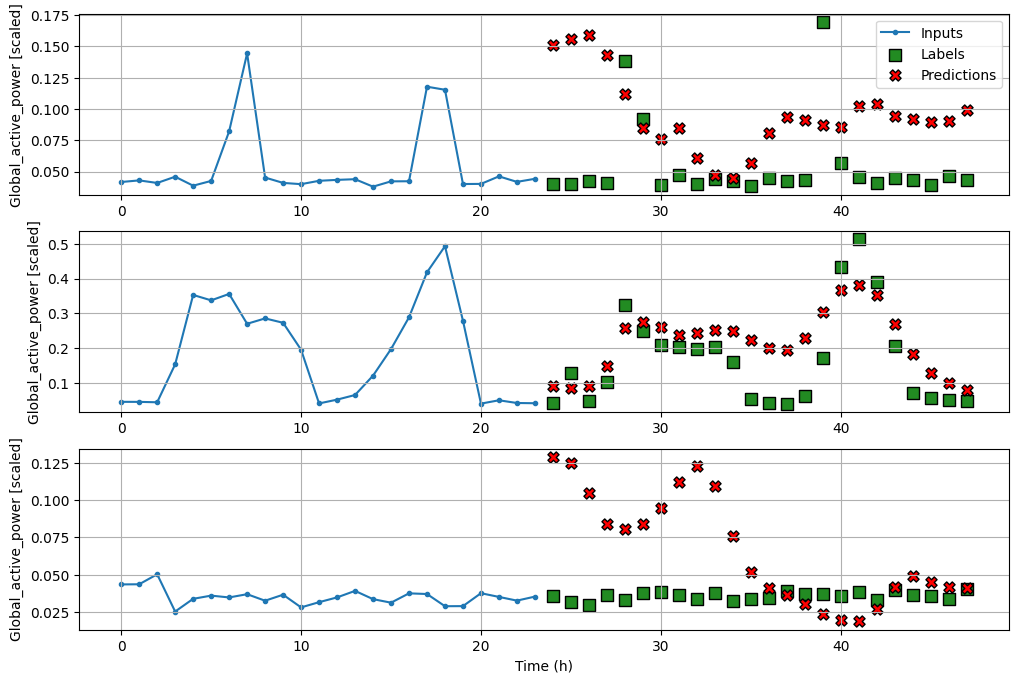

In [23]:
multi_window.plot(lstm_model)

#### Convolutional Neural Network (CNN)

In [24]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['Global_active_power'])

In [25]:
# CNN Model Set-Up
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

# Model Training
history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
756/756 [==============================] - 1s 836us/step - loss: 0.0148 - mean_absolute_error: 0.0898 - val_loss: 0.0119 - val_mean_absolute_error: 0.0789
Epoch 2/50
756/756 [==============================] - 1s 797us/step - loss: 0.0136 - mean_absolute_error: 0.0852 - val_loss: 0.0120 - val_mean_absolute_error: 0.0834
Epoch 3/50
756/756 [==============================] - 1s 842us/step - loss: 0.0135 - mean_absolute_error: 0.0848 - val_loss: 0.0116 - val_mean_absolute_error: 0.0789
Epoch 4/50
756/756 [==============================] - 1s 801us/step - loss: 0.0134 - mean_absolute_error: 0.0842 - val_loss: 0.0116 - val_mean_absolute_error: 0.0809
Epoch 5/50
756/756 [==============================] - 1s 794us/step - loss: 0.0134 - mean_absolute_error: 0.0840 - val_loss: 0.0115 - val_mean_absolute_error: 0.0802
Epoch 6/50
756/756 [==============================] - 1s 791us/step - loss: 0.0133 - mean_absolute_error: 0.0837 - val_loss: 0.0116 - val_mean_absolute_error: 0.0798
Epoc

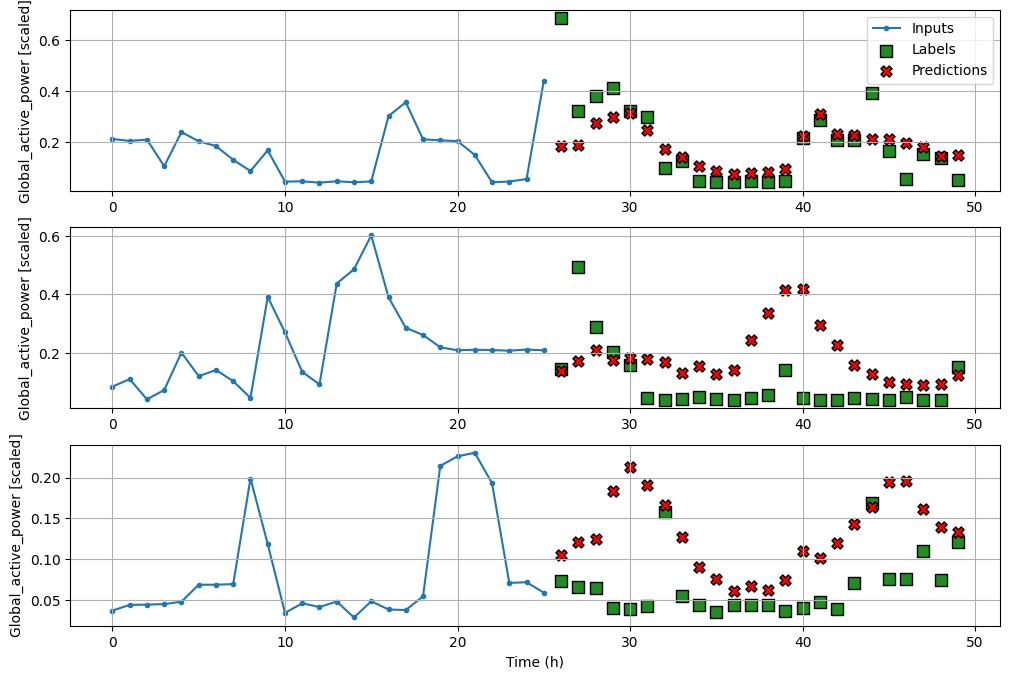

In [26]:
cnn_multi_window.plot(cnn_model)

#### Combining CNN & LSTM

In [27]:
# CNN + LSTM Model Set-Up
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

# Model Training
history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
756/756 [==============================] - 3s 3ms/step - loss: 0.0153 - mean_absolute_error: 0.0917 - val_loss: 0.0116 - val_mean_absolute_error: 0.0796
Epoch 2/50
756/756 [==============================] - 2s 3ms/step - loss: 0.0134 - mean_absolute_error: 0.0844 - val_loss: 0.0115 - val_mean_absolute_error: 0.0789
Epoch 3/50
756/756 [==============================] - 2s 3ms/step - loss: 0.0133 - mean_absolute_error: 0.0836 - val_loss: 0.0114 - val_mean_absolute_error: 0.0789
Epoch 4/50
756/756 [==============================] - 2s 3ms/step - loss: 0.0132 - mean_absolute_error: 0.0832 - val_loss: 0.0115 - val_mean_absolute_error: 0.0791
Epoch 5/50
756/756 [==============================] - 2s 3ms/step - loss: 0.0131 - mean_absolute_error: 0.0829 - val_loss: 0.0115 - val_mean_absolute_error: 0.0802
Epoch 6/50
756/756 [==============================] - 2s 3ms/step - loss: 0.0130 - mean_absolute_error: 0.0825 - val_loss: 0.0113 - val_mean_absolute_error: 0.0774
Epoch 7/50
756/7

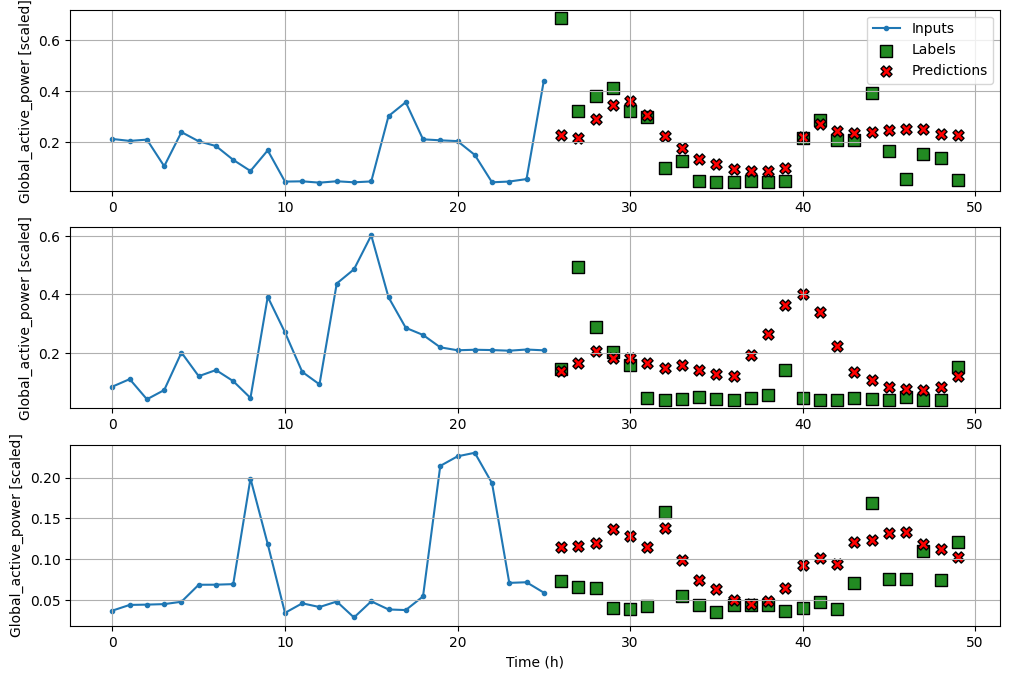

In [28]:
cnn_multi_window.plot(cnn_lstm_model)

#### Autoregressive LSTM

##### AutoRegressive Class

In [29]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [30]:
# ARLSTM Model Set-Up
AR_LSTM = AutoRegressive(units=32, out_steps=24)

# Model Training
history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
756/756 [==============================] - 4s 4ms/step - loss: 0.0168 - mean_absolute_error: 0.0990 - val_loss: 0.0120 - val_mean_absolute_error: 0.0837
Epoch 2/50
756/756 [==============================] - 2s 3ms/step - loss: 0.0135 - mean_absolute_error: 0.0851 - val_loss: 0.0116 - val_mean_absolute_error: 0.0827
Epoch 3/50
756/756 [==============================] - 2s 3ms/step - loss: 0.0133 - mean_absolute_error: 0.0838 - val_loss: 0.0116 - val_mean_absolute_error: 0.0818
Epoch 4/50
756/756 [==============================] - 2s 3ms/step - loss: 0.0131 - mean_absolute_error: 0.0831 - val_loss: 0.0114 - val_mean_absolute_error: 0.0793
Epoch 5/50
756/756 [==============================] - 2s 3ms/step - loss: 0.0130 - mean_absolute_error: 0.0825 - val_loss: 0.0110 - val_mean_absolute_error: 0.0784
Epoch 6/50
756/756 [==============================] - 2s 3ms/step - loss: 0.0129 - mean_absolute_error: 0.0823 - val_loss: 0.0112 - val_mean_absolute_error: 0.0793
Epoch 7/50
756/7

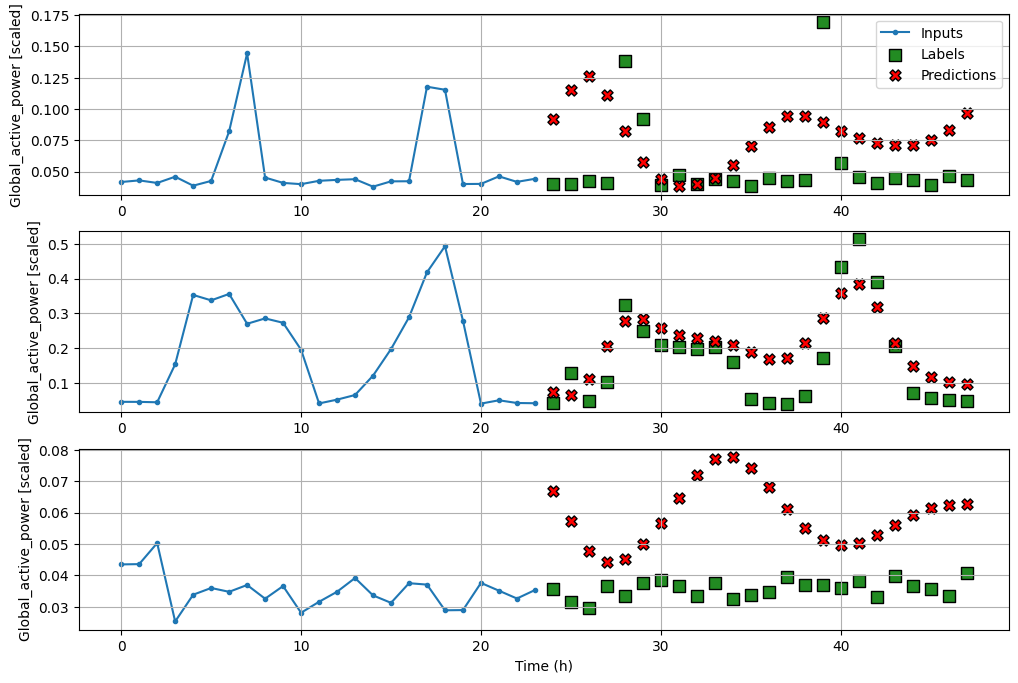

In [31]:
multi_window.plot(AR_LSTM)

### Best Model Selection

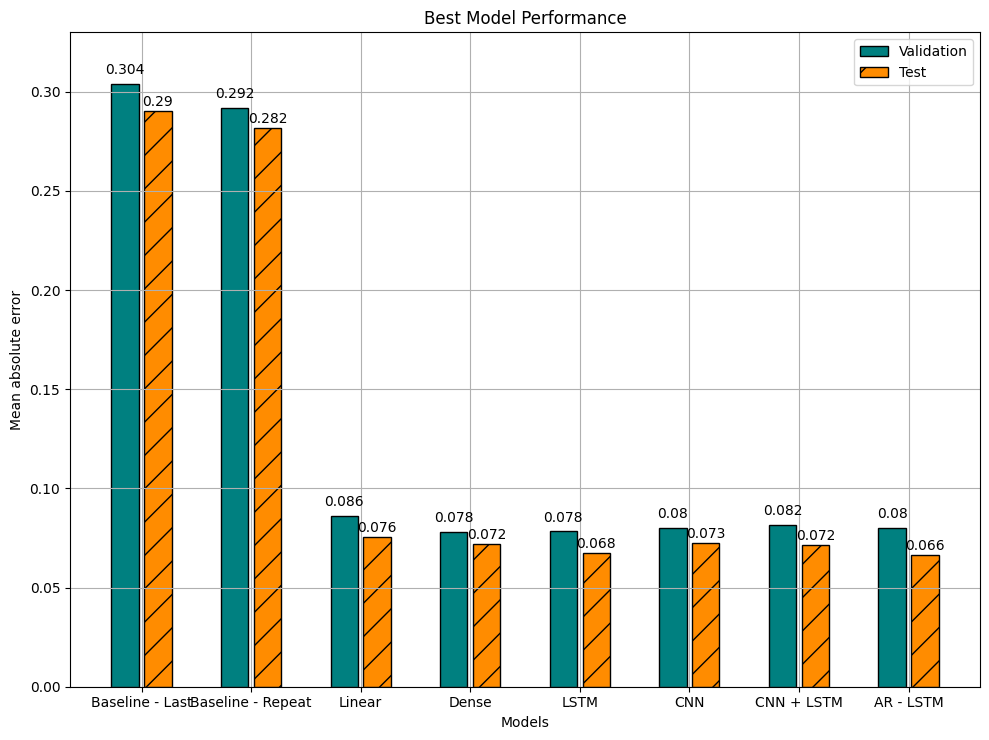

In [32]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='teal', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='darkorange', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.005, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.title('Best Model Performance')
plt.tight_layout()
plt.show()